# Plot Compound Years for CESM

You need to run cesmIndeces.ipnyb first

In [1]:
#import my functions
import sys
sys.path.append('../')

#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.overlapBins as overlapBins

In [2]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.stats

%matplotlib inline

In [3]:
#The data
firePos=xarray.open_dataset('results/cesmFirePos.nc')
fireNeg=xarray.open_dataset('results/cesmFireNeg.nc')

# A function

Plot the multi-experiment mean using vertical lines in each bin 

In [4]:
toPlot=[ #*firePos.attrs['indeces'],
    *firePos.attrs['pairs'],'all3']
colors=['orange', 'purple', 'green','blue']

def binPlot(da, expSet):

    plt.figure(figsize=(18,6))

    for counter in range(0,len(toPlot)):
        plt.vlines(
            x=da.year-len(toPlot)+1.5*counter, 
            ymin=0,
            ymax=da[toPlot[counter]].sel(experiment=expSet).mean(dim='experiment'),
            label=toPlot[counter],
            color=colors[counter]
        )

    plt.legend(loc='upper left')
    plt.xticks(ticks=da.year)
    plt.xlim(1700,2100)
    plt.xlabel('Mid-point of 30 year bin')
    plt.ylim(0,8)
    plt.ylabel('Number of events (mean)')
    plt.title('Pairs and all-three for runs with ' + str(expSet))
    plt.minorticks_on()

# In non-overlapping 30 year bins

Calculate non-overlapping 30 year bins, and sum the number of events in them

In [5]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

#binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).sum() #This line is a bit problematic. If you have all nans in the bin, it will give you a sum of 0. It is probably more useful to return a nan

#Do the sum for each interval, but only it there are no Nans.
binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid).map(
    lambda ds : ds.sum(dim='year').where(ds.isnull().any(dim='year')!=True)
)
binnedFirePos=binnedFirePos.rename({'year_bins':'year'})


In [6]:
#check that years with no data are nan
binnedFirePos.sel(experiment='002')

<xarray.Dataset>
Dimensions:      (year: 41)
Coordinates:
  * year         (year) int64 875 905 935 965 995 ... 1955 1985 2015 2045 2075
    experiment   <U3 '002'
Data variables:
    dmi          (year) float64 3.0 1.0 2.0 3.0 3.0 5.0 ... 0.0 3.0 nan nan nan
    nino34       (year) float64 0.0 0.0 0.0 0.0 2.0 1.0 ... 2.0 1.0 nan nan nan
    sam          (year) float64 6.0 5.0 4.0 9.0 4.0 4.0 ... 5.0 0.0 nan nan nan
    nEvents      (year) float64 26.0 16.0 17.0 23.0 20.0 ... 12.0 nan nan nan
    all3         (year) float64 5.0 2.0 1.0 1.0 1.0 0.0 ... 1.0 0.0 nan nan nan
    nino34+dmi   (year) float64 0.0 0.0 4.0 2.0 3.0 0.0 ... 3.0 4.0 nan nan nan
    nino34+sam   (year) float64 0.0 1.0 0.0 1.0 0.0 1.0 ... 1.0 0.0 nan nan nan
    dmi+sam      (year) float64 1.0 1.0 0.0 1.0 1.0 1.0 ... 0.0 0.0 nan nan nan
    anyCompound  (year) float64 6.0 4.0 5.0 5.0 5.0 2.0 ... 5.0 4.0 nan nan nan

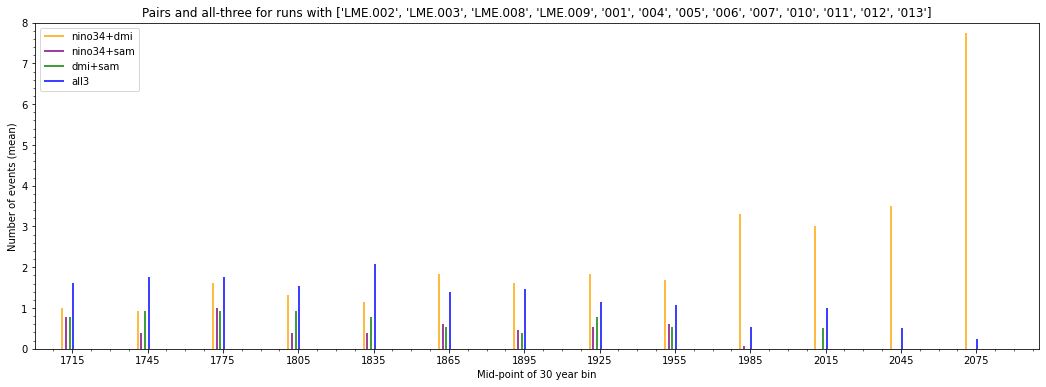

In [7]:
binPlot(binnedFirePos, _model.cesmNoRepeats)

Group into three time periods: pre 1850, 1850-2005 and 2005 to 2100

In [8]:
groupA = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(850,1850))
groupB = binnedFirePos.sel(experiment=_model.cesmNoRepeats, year=slice(1850,2006))
groupC = binnedFirePos.sel(experiment=_model.cesmRcp85, year=slice(2006,2100))

In [9]:
groupC.nino34.values.flatten()

array([0., 1., 1., 1., 3., 2., 1., 3., 0., 2., 0., 2.])

In [10]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.f_oneway(
        groupA[iInd].values.flatten() , 
        groupB[iInd].values.flatten(), 
        groupC[iInd].values.flatten()
        )
    )

nino34+dmi
F_onewayResult(statistic=55.16097178313521, pvalue=2.1912386251156325e-22)
nino34+sam
F_onewayResult(statistic=5.364711238204568, pvalue=0.004950359168891299)
dmi+sam
F_onewayResult(statistic=7.0611071277087, pvalue=0.0009454963576984352)
all3
F_onewayResult(statistic=11.58508225234114, pvalue=1.2053252813308302e-05)


In [11]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.ttest_ind(groupA[iInd].values.flatten() , 
        groupB[iInd].values.flatten())
    )
    

nino34+dmi
Ttest_indResult(statistic=-4.4526780215668795, pvalue=1.0503432709625514e-05)
nino34+sam
Ttest_indResult(statistic=1.6404297310381832, pvalue=0.10155497189791542)
dmi+sam
Ttest_indResult(statistic=2.90410928047, pvalue=0.0038486082556662368)
all3
Ttest_indResult(statistic=3.6173225295063376, pvalue=0.0003284142289977348)


In [12]:
for iInd in toPlot:
    print(iInd)
    print(
        scipy.stats.ttest_ind(groupA[iInd].values.flatten() , 
        groupC[iInd].values.flatten())
    )
    

nino34+dmi
Ttest_indResult(statistic=-10.092817522133252, pvalue=1.1137976730504202e-21)
nino34+sam
Ttest_indResult(statistic=2.8591658544808918, pvalue=0.004449931077304754)
dmi+sam
Ttest_indResult(statistic=2.501454531494464, pvalue=0.012731540907936803)
all3
Ttest_indResult(statistic=3.359293470662223, pvalue=0.0008496129026643314)


In [13]:
def mySlowFunction(input):
    y=input[0]
    if y<1850:
        result='A'
    elif y<2006:
        result='B'
    else:
        result='C'
        
    return result

<AxesSubplot:title={'center':'nino34'}, xlabel='[<function mySlowFunction at 0x7ff6d1e334c0>]'>

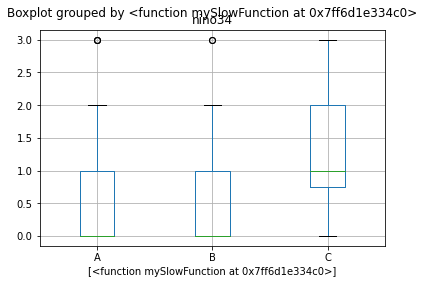

In [14]:
binnedFirePos.sel(experiment=_model.cesmNoRepeats).nino34.to_dataframe().boxplot(by=mySlowFunction)


# In overlapping 30 year bins

In [22]:
overBinFirePos = overlapBins.binSum(firePos)
overBinFireNeg = overlapBins.binSum(fireNeg)

In [23]:
overBinFirePos

<xarray.Dataset>
Dimensions:      (experiment: 18, year: 123)
Coordinates:
  * experiment   (experiment) object 'LME.002' 'LME.003' ... '012' '013'
  * year         (year) int64 865 875 885 895 905 ... 2045 2055 2065 2075 2085
Data variables:
    dmi          (year, experiment) float64 4.0 2.0 4.0 1.0 ... nan nan nan nan
    nino34       (year, experiment) float64 0.0 0.0 0.0 1.0 ... nan nan nan nan
    sam          (year, experiment) float64 9.0 4.0 5.0 5.0 ... nan nan nan nan
    nEvents      (year, experiment) float64 24.0 18.0 22.0 18.0 ... nan nan nan
    all3         (year, experiment) float64 3.0 2.0 1.0 1.0 ... nan nan nan nan
    nino34+dmi   (year, experiment) float64 1.0 2.0 2.0 1.0 ... nan nan nan nan
    nino34+sam   (year, experiment) float64 0.0 1.0 1.0 3.0 ... nan nan nan nan
    dmi+sam      (year, experiment) float64 0.0 0.0 2.0 0.0 ... nan nan nan nan
    anyCompound  (year, experiment) float64 4.0 5.0 6.0 5.0 ... nan nan nan nan
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

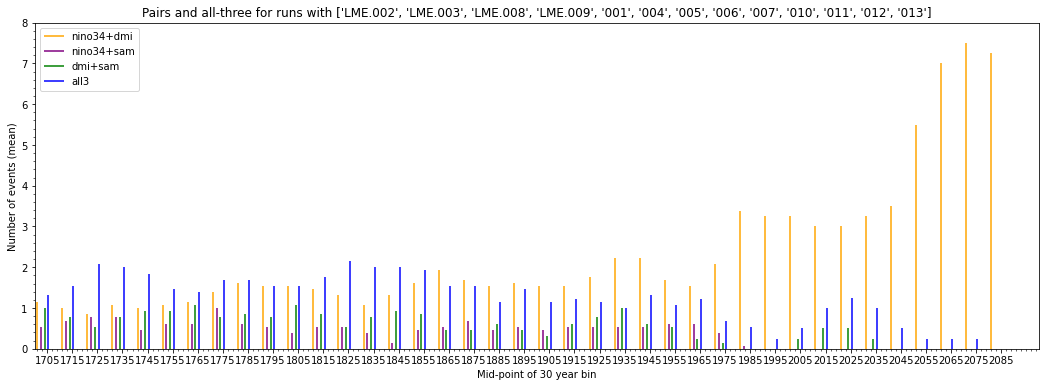

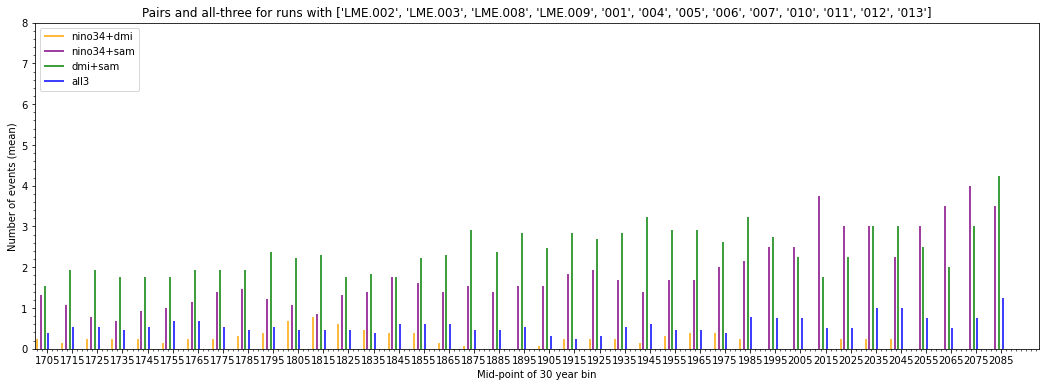

In [24]:
binPlot(overBinFirePos, _model.cesmNoRepeats)
binPlot(overBinFireNeg, _model.cesmNoRepeats)

# Time of emergence?

Function to calcuate 95% CI from pre-1850 results, and plot against all data.

    Confidence Interval	Z

    90%	1.645

    95%	1.960

In [44]:
def emergePlot(binnedXr):

    meanXr=binnedXr.where(binnedXr.year<1850).mean(dim='experiment')

    # plot indeces for an experiment, and add some lines for CI

    #Z = 1.645
    Z=1.96

    indexToPlot = list(binnedXr.data_vars)

    # first define somewhere to plot
    fig = plt.figure(figsize=(18,24))

    nIndices=len(indexToPlot)

    for i in range(nIndices):

        fig.add_subplot(nIndices,1,i+1)


        # plot the actual data
        plotData=binnedXr[indexToPlot[i]]

        plt.plot(plotData.year, plotData.mean(dim='experiment').values, label=indexToPlot[i])
        plt.fill_between(plotData.year, plotData.min(dim='experiment').values, plotData.max(dim='experiment').values, color='lightblue')


        #cI=Z*overBinFirePos[indexToPlot[i]].sel(experiment=_model.cesmNoRepeats).std(dim='experiment')
        #plt.fill_between(x=plotData.year.values, y1=(plotData-cI).values, y2=(plotData+cI).values, color='lightblue')

        # draw some horizontal lines for criteria
        plt.axhline(y=meanXr[indexToPlot[i]].mean()+Z*meanXr[indexToPlot[i]].std(), dashes=(5,5), color='black')
        plt.axhline(y=meanXr[indexToPlot[i]].mean()-Z*meanXr[indexToPlot[i]].std(), dashes=(5,5), color='black')

        plt.axvline(x=1990)
        
        #Tidy up a bit
        plt.xlabel('year')
        plt.ylabel('number of events/30 years')
        plt.xlim(1000,2100)
        #plt.ylim(0,10)
        plt.minorticks_on()
        plt.legend()


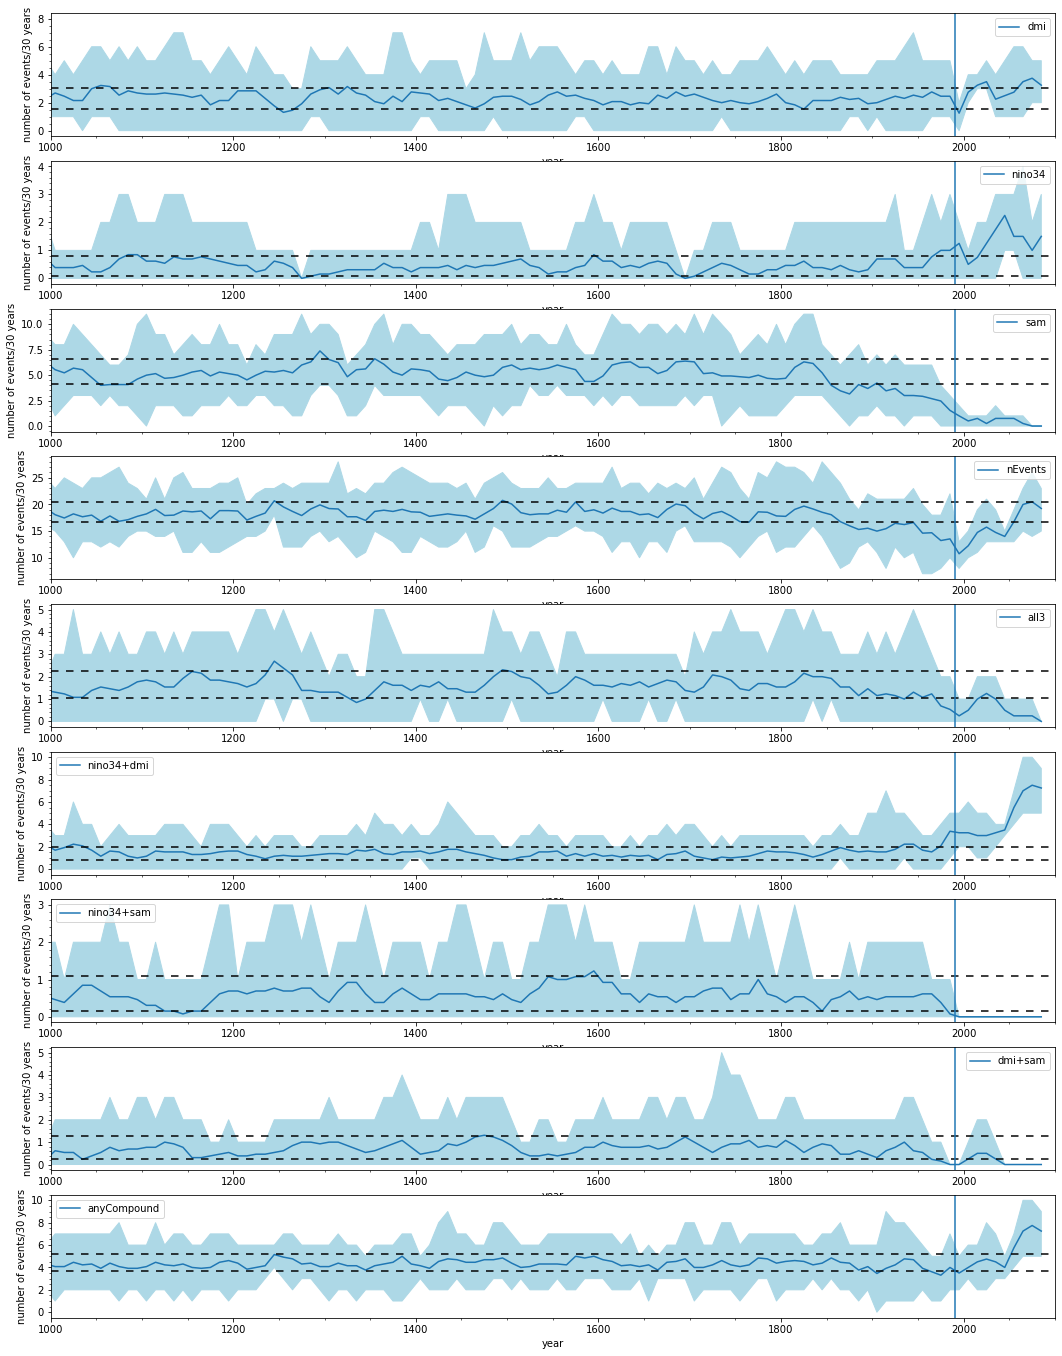

In [45]:
emergePlot(overBinFirePos.sel(experiment=_model.cesmNoRepeats))

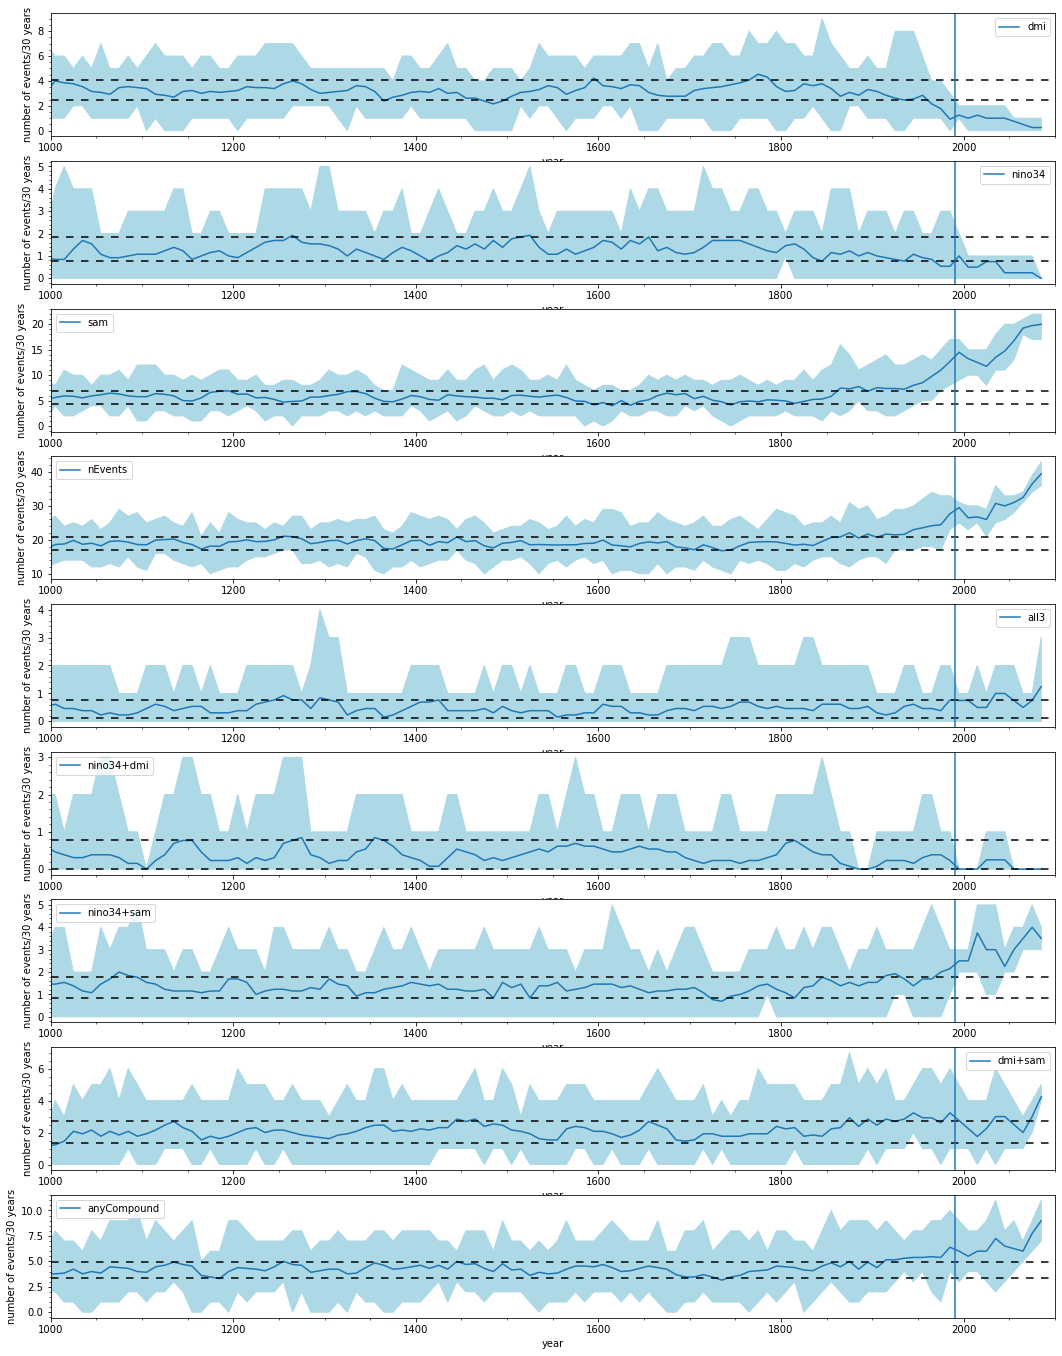

In [46]:
emergePlot(overBinFireNeg.sel(experiment=_model.cesmNoRepeats))